In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

% matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD

from datetime import datetime
from dateutil.relativedelta import relativedelta

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from funcs_var import *

Using TensorFlow backend.


## Data Collection

#### short term interst rate

In [2]:
stir = pd.read_csv('var_ru/ru_stir.csv')

In [3]:
stir = stir[['TIME', 'Value']].copy()

In [4]:
stir['TIME'] = pd.to_datetime(stir['TIME'])

In [5]:
stir.index = stir['TIME']

In [6]:
stir = stir[['Value']].copy()

In [7]:
stir['date'] = stir.index.tolist()

#### inflation rate

In [8]:
infr = pd.read_csv('var_ru/ru_inf.csv')

In [9]:
infr = infr.sort_index(axis=0, ascending=False).reset_index(drop=True)

In [10]:
inf_l = []
for i in range(len(infr.iloc[:, 1:13])):
    inf_l = inf_l + infr.iloc[i, 1:13].tolist()

In [11]:
inf_l = inf_l[:-8]

In [12]:
for i in range(len(inf_l)):
    inf_l[i] = inf_l[i].replace(',', '.')

In [13]:
for i in range(len(inf_l)):
    inf_l[i] = float(inf_l[i])

In [14]:
date_list = []
for i in range(len(inf_l)):
    date_list.append(datetime.strptime('1991-01', '%Y-%M') + relativedelta(months=i))

In [15]:
infr = pd.DataFrame(inf_l, date_list, ['Value']).iloc[:-4, :]

In [16]:
q_list = []
for y in range(1991, 2017):
    for q in ['Q1', 'Q1', 'Q1', 'Q2', 'Q2', 'Q2', 'Q3', 'Q3', 'Q3', 'Q4', 'Q4', 'Q4']:
        q_list.append(str(y)+q)

In [17]:
infr['q'] = q_list

In [18]:
g = infr.groupby('q')['Value']
quarters = pd.unique(infr['q']).tolist()

In [19]:
ir_q = []
for q in quarters:
    l_g = g.get_group(q).tolist()
    l_g_m = [i*0.01 for i in l_g]
    current = 1
    for i in l_g_m:
        current = current + current*i
    ir_q.append((current-1)*100)

In [20]:
infr = pd.DataFrame([ir_q, pd.to_datetime(quarters).tolist()], ['Value', 'date']).T

#### GDP

In [21]:
gdp = pd.read_csv('var_ru/ru_gdp_real.csv')

In [22]:
gdp_l = gdp.T.iloc[1:, 1].tolist()

In [23]:
for i in range(len(gdp_l)):
    gdp_l[i] = str(gdp_l[i])

In [24]:
for i in range(len(gdp_l)):
    gdp_l[i] = gdp_l[i].replace(',', '.')

In [25]:
for i in range(len(gdp_l)):
    gdp_l[i] = float(gdp_l[i])

In [26]:
date_list = []
for i in range(0, len(gdp_l)*3, 3):
    date_list.append(datetime.strptime('1995-01', '%Y-%m') + relativedelta(months=i))

In [27]:
gdp = pd.DataFrame(gdp_l, date_list, ['Value'])

In [28]:
gdp['date'] = gdp.index.tolist()

#### Make full df

In [29]:
gdp.index = gdp['date']
gdp = gdp[['Value']].copy()
stir.index = stir['date']
stir = stir[['Value']].copy()
infr.index = infr['date']
infr = infr[['Value']].copy()

In [30]:
df_var_t = pd.concat([gdp, stir, infr], axis=1).dropna()
df_var_t.columns = ['gdp', 'stir', 'infr']

Results of Dickey-Fuller Test:
Test Statistic                 -1.359580
p-value                         0.601493
#Lags Used                      1.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (10%)           -2.587498
Critical Value (5%)            -2.900395
dtype: float64


Results of KPSS Test:
Test Statistic            0.669773
p-value                   0.016293
#Lags Used               12.000000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
dtype: float64


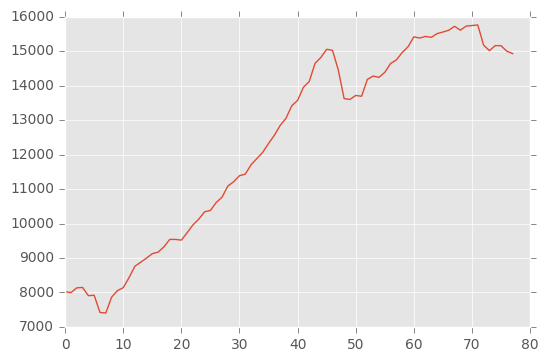

In [31]:
test_stationarity(df_var_t['gdp'])

Results of Dickey-Fuller Test:
Test Statistic                 -1.878809
p-value                         0.342095
#Lags Used                      3.000000
Number of Observations Used    74.000000
Critical Value (1%)            -3.521980
Critical Value (10%)           -2.588072
Critical Value (5%)            -2.901470
dtype: float64


Results of KPSS Test:
Test Statistic            0.375694
p-value                   0.087632
#Lags Used               12.000000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
dtype: float64


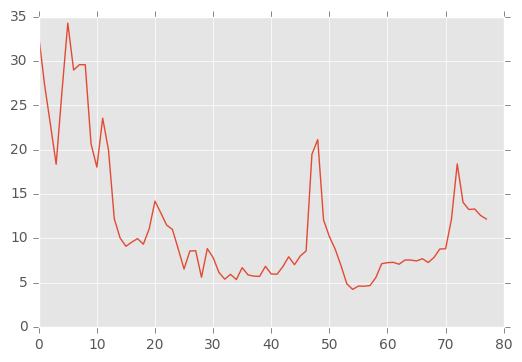

In [32]:
test_stationarity(df_var_t['stir'])

Results of Dickey-Fuller Test:
Test Statistic                 -3.573402
p-value                         0.006290
#Lags Used                     12.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (10%)           -2.591103
Critical Value (5%)            -2.907154
dtype: float64


Results of KPSS Test:
Test Statistic            0.412117
p-value                   0.071932
#Lags Used               12.000000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
dtype: float64


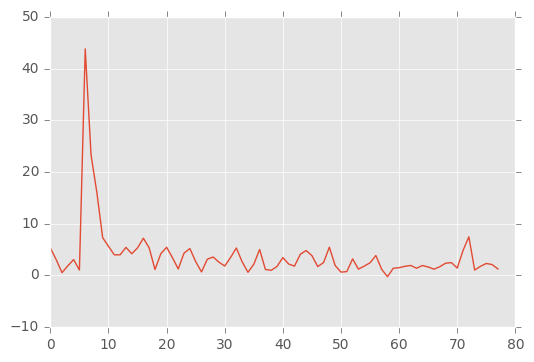

In [33]:
test_stationarity(df_var_t['infr'])

Рвзности

Results of Dickey-Fuller Test:
Test Statistic                 -5.575741
p-value                         0.000001
#Lags Used                      0.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (10%)           -2.587498
Critical Value (5%)            -2.900395
dtype: float64


Results of KPSS Test:
Test Statistic            0.235576
p-value                   0.100000
#Lags Used               12.000000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


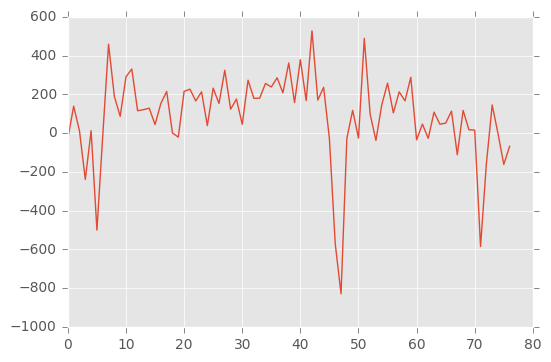

In [34]:
test_stationarity(diff_series(df_var_t['gdp']))

Results of Dickey-Fuller Test:
Test Statistic                -8.596966e+00
p-value                        7.034930e-14
#Lags Used                     1.000000e+00
Number of Observations Used    7.500000e+01
Critical Value (1%)           -3.520713e+00
Critical Value (10%)          -2.587781e+00
Critical Value (5%)           -2.900925e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.398520
p-value                   0.077793
#Lags Used               12.000000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
dtype: float64


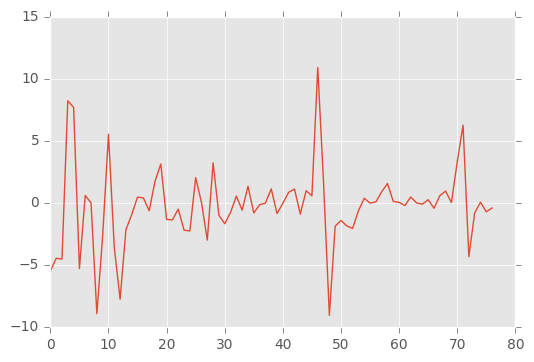

In [35]:
test_stationarity(diff_series(df_var_t['stir']))

Results of Dickey-Fuller Test:
Test Statistic                -7.011675e+00
p-value                        6.896144e-10
#Lags Used                     2.000000e+00
Number of Observations Used    7.400000e+01
Critical Value (1%)           -3.521980e+00
Critical Value (10%)          -2.588072e+00
Critical Value (5%)           -2.901470e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.08435
p-value                   0.10000
#Lags Used               12.00000
Critical Value (2.5%)     0.57400
Critical Value (10%)      0.34700
Critical Value (1%)       0.73900
Critical Value (5%)       0.46300
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


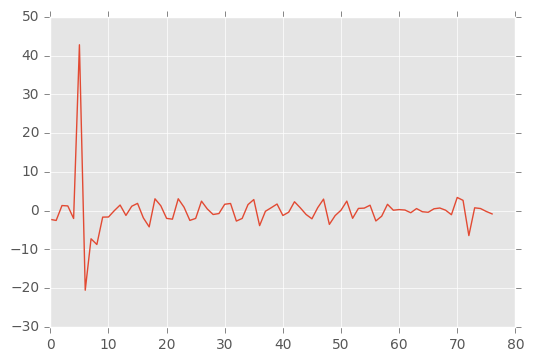

In [36]:
test_stationarity(diff_series(df_var_t['infr']))

In [37]:
df_var_t_diff = diff_series(df_var_t)

## Forecasting

In [38]:
STEPS = 6
LAG = 4

In [39]:
train = df_var_t_diff.iloc[:-STEPS, :]
test = df_var_t_diff.iloc[-STEPS:, :]

train_real = df_var_t.iloc[:-STEPS, :]
test_real = df_var_t.iloc[-STEPS:, :]

### VAR

In [40]:
def var_model(train, steps, lags, years=None, period='m'):
    df = np.array(train)
    years_out=None
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(b, p+1, s)]
    model = VAR(df)
    fitm = model.fit(maxlags=lags)
    var_in = pd.DataFrame(fitm.fittedvalues, 
                          columns=train.columns, 
                          index=years)
    var_out = fitm.forecast(y=df, steps=steps)
    var_out = pd.DataFrame(var_out, 
                           columns=train.columns, 
                           index=years_out)
    return {'in':var_in, 'out':var_out}

In [41]:
var_result = var_model(train, steps=STEPS, lags=LAG, years=train.index[LAG:], period='q')
print(error(var_result['out']['stir'], test['stir']))
print(error(var_result['out']['infr'], test['infr']))
print(error(var_result['out']['gdp'], test['gdp']))

{'mse': 6.2528321417123998, 'mae': 1.4687940159904596, 'rmse': 2.500566364188801}
{'mse': 13.589530920765784, 'mae': 2.8347884901141174, 'rmse': 3.6863980958064992}
{'mse': 88941.045021697646, 'mae': 248.78021618770674, 'rmse': 298.22985266686106}


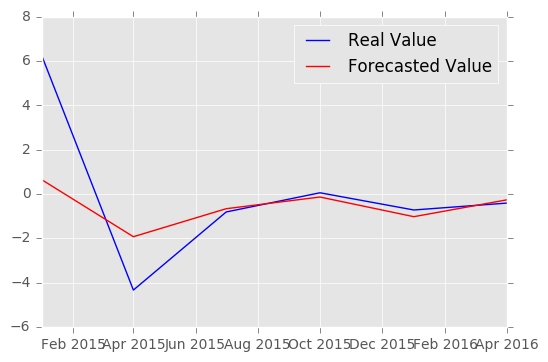

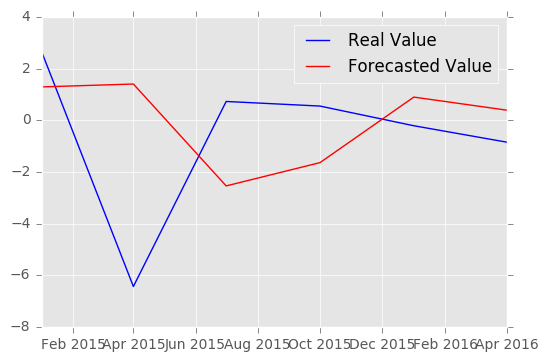

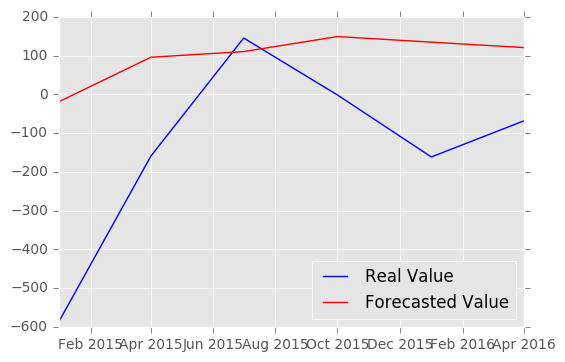

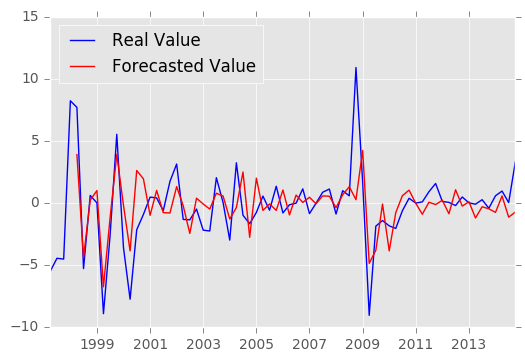

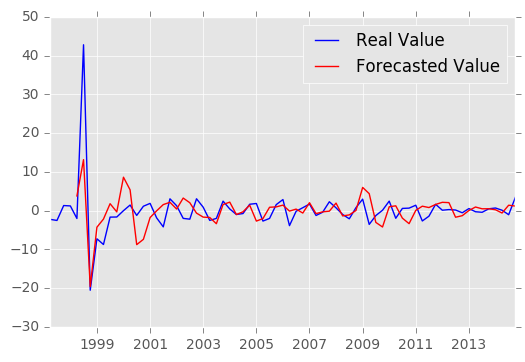

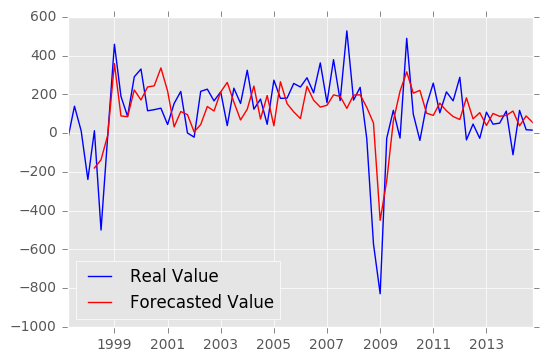

In [42]:
plot_compar(var_result['out']['stir'], test['stir'])
plot_compar(var_result['out']['infr'], test['infr'])
plot_compar(var_result['out']['gdp'], test['gdp'])
plot_compar(var_result['in']['stir'], train['stir'])
plot_compar(var_result['in']['infr'], train['infr'])
plot_compar(var_result['in']['gdp'], train['gdp'])

{'mse': 14.336231227283688, 'mae': 3.6830157807632875, 'rmse': 3.7863215958610392}
{'mse': 11.813818585700886, 'mae': 2.9239518003602822, 'rmse': 3.4371235918571341}
{'mse': 1006924.9067960089, 'mae': 961.60776842973667, 'rmse': 1003.4564797717981}


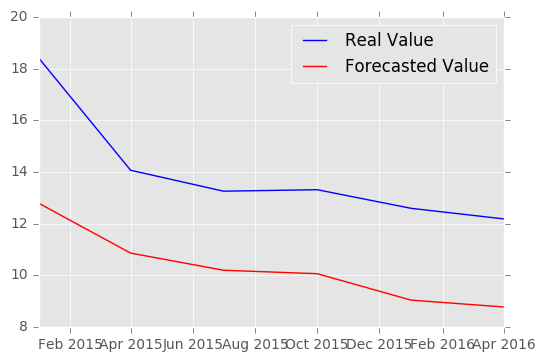

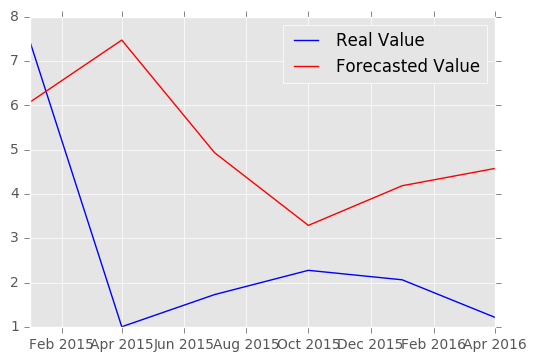

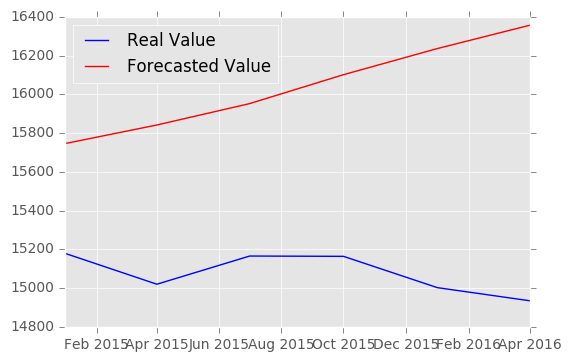

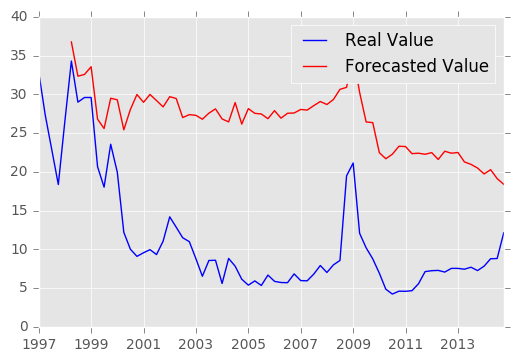

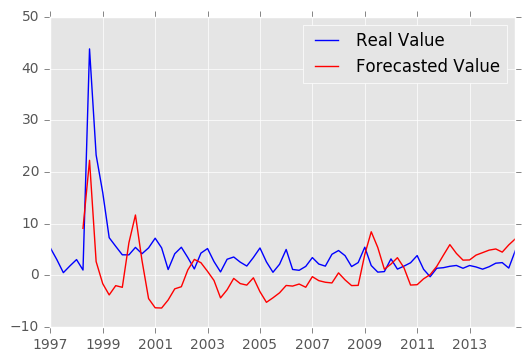

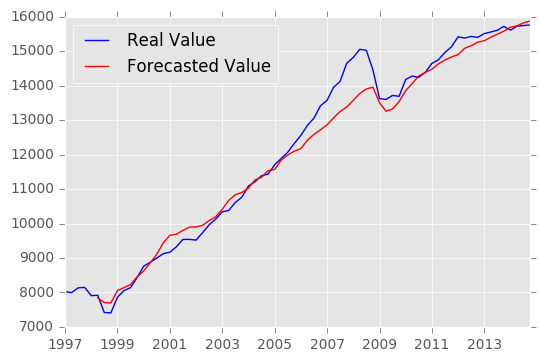

In [43]:
var_undiff_out = undiff(previous_df=train_real, diff_df=var_result['out'])
var_undiff_in = undiff(previous_df=train_real.head(1), diff_df=var_result['in'])
print(error(var_undiff_out['stir'], test_real['stir']))
print(error(var_undiff_out['infr'], test_real['infr']))
print(error(var_undiff_out['gdp'], test_real['gdp']))
plot_compar(var_undiff_out['stir'], test_real['stir'])
plot_compar(var_undiff_out['infr'], test_real['infr'])
plot_compar(var_undiff_out['gdp'], test_real['gdp'])
plot_compar(var_undiff_in['stir'], train_real['stir'])
plot_compar(var_undiff_in['infr'], train_real['infr'])
plot_compar(var_undiff_in['gdp'], train_real['gdp'])

## ANN

In [44]:
df_nn = nn_transform(train, n=LAG)
df_nn_s, m, s = scaler(df_nn)
train_nn_x = df_nn_s.iloc[:, 3:].copy()
train_nn_y = df_nn_s.iloc[:, :3].copy()

In [45]:
def nn_model(x, y, n_feat, lag, steps, model, years=None, epoch=100, period='q'):
    years_out=None
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(b, p+1, s)]
    model.fit(np.array(x), np.array(y),
       nb_epoch=epoch, 
       verbose=2,
       batch_size=1)
    nn_in = pd.DataFrame(model.predict(np.array(x)), 
                         columns=y.columns, 
                         index=years)
    nn_out = nn_predict(model, train, lags=lag, steps=steps)
    if years is not None:
        nn_out.index = years_out
    return {'in':nn_in, 'out':nn_out}

Первый запуск

In [46]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [47]:
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=500)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/500
0s - loss: 1.1644
Epoch 2/500
0s - loss: 1.0514
Epoch 3/500
0s - loss: 1.0091
Epoch 4/500
0s - loss: 0.9954
Epoch 5/500
0s - loss: 0.9884
Epoch 6/500
0s - loss: 0.9845
Epoch 7/500
0s - loss: 0.9754
Epoch 8/500
0s - loss: 0.9745
Epoch 9/500
0s - loss: 0.9685
Epoch 10/500
0s - loss: 0.9648
Epoch 11/500
0s - loss: 0.9642
Epoch 12/500
0s - loss: 0.9572
Epoch 13/500
0s - loss: 0.9584
Epoch 14/500
0s - loss: 0.9543
Epoch 15/500
0s - loss: 0.9513
Epoch 16/500
0s - loss: 0.9451
Epoch 17/500
0s - loss: 0.9445
Epoch 18/500
0s - loss: 0.9368
Epoch 19/500
0s - loss: 0.9366
Epoch 20/500
0s - loss: 0.9306
Epoch 21/500
0s - loss: 0.9274
Epoch 22/500
0s - loss: 0.9262
Epoch 23/500
0s - loss: 0.9230
Epoch 24/500
0s - loss: 0.9203
Epoch 25/500
0s - loss: 0.9151
Epoch 26/500
0s - loss: 0.9096
Epoch 27/500
0s - loss: 0.9095
Epoch 28/500
0s - loss: 0.9023
Epoch 29/500
0s - loss: 0.8993
Epoch 30/500
0s - loss: 0.8973
Epoch 31/500
0s - loss: 0.8911
Epoch 32/500
0s - loss: 0.8863
Epoch 33/500
0s -

{'mse': 32.30689898916112, 'mae': 4.9521007259940371, 'rmse': 5.6839158147496445}
{'mse': 71.686045884847829, 'mae': 5.8353880805415388, 'rmse': 8.466761239390646}
{'mse': 114731.70642262818, 'mae': 262.23003404078986, 'rmse': 338.72069086878673}


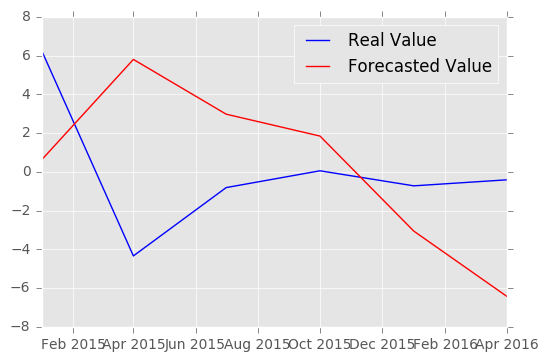

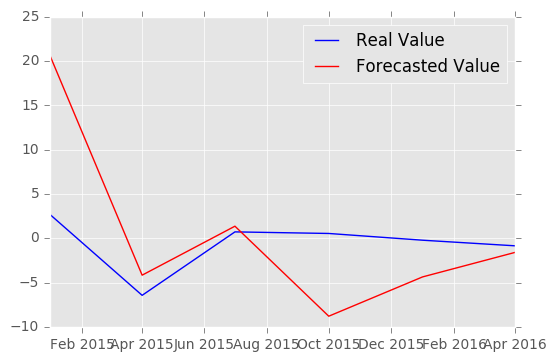

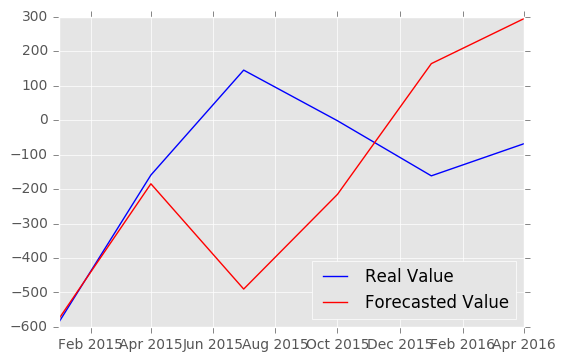

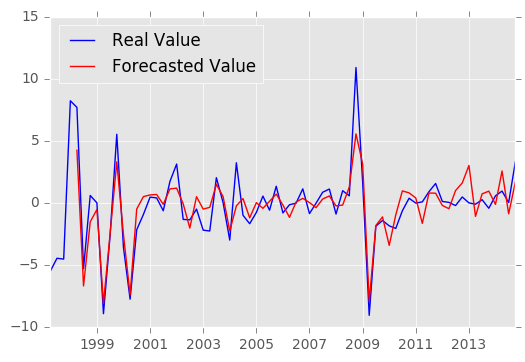

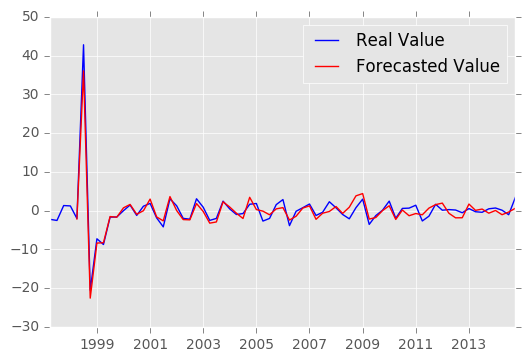

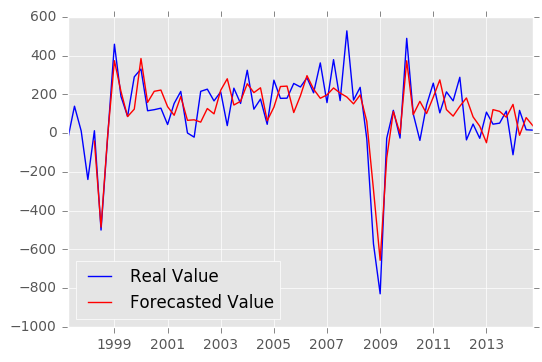

In [48]:
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['gdp'], test['gdp']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['gdp'], test['gdp'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['gdp'], train['gdp'])

{'mse': 47.51034087642347, 'mae': 6.3280048942922802, 'rmse': 6.8927745412441475}
{'mse': 231.01717847364168, 'mae': 14.028206969566492, 'rmse': 15.199249273356948}
{'mse': 248840.37104497245, 'mae': 375.9286968434987, 'rmse': 498.83902317779075}


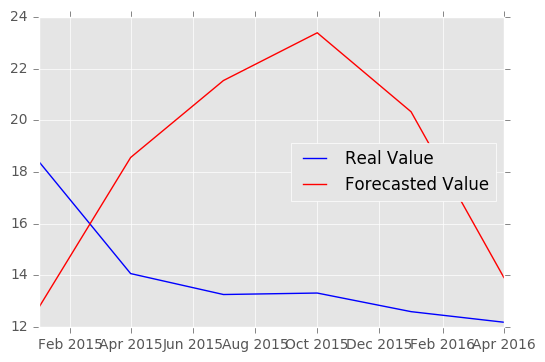

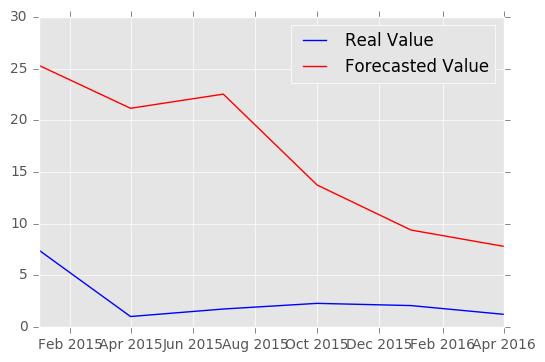

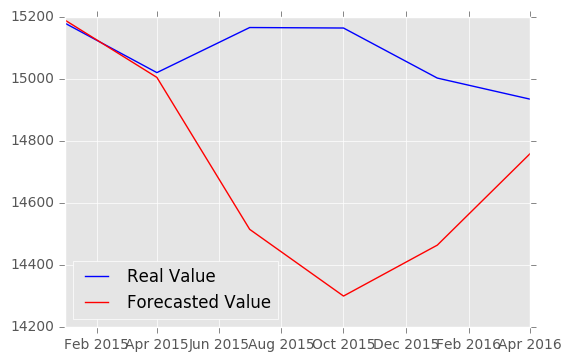

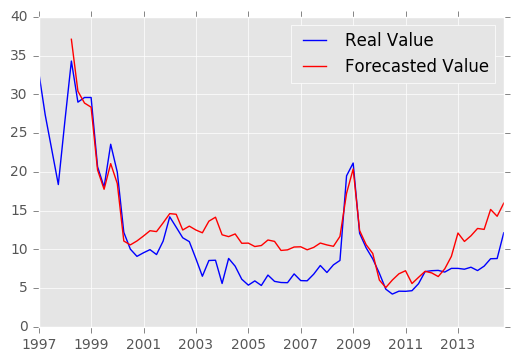

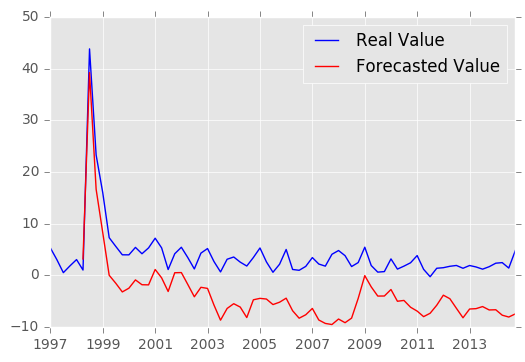

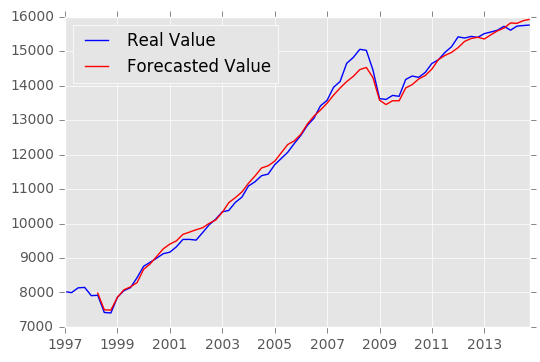

In [49]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['gdp'], test_real['gdp']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['gdp'], test_real['gdp'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['gdp'], train_real['gdp'])

Второй запуск

In [50]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
0s - loss: 1.0698
Epoch 2/600
0s - loss: 1.0153
Epoch 3/600
0s - loss: 0.9996
Epoch 4/600
0s - loss: 0.9956
Epoch 5/600
0s - loss: 0.9886
Epoch 6/600
0s - loss: 0.9837
Epoch 7/600
0s - loss: 0.9800
Epoch 8/600
0s - loss: 0.9751
Epoch 9/600
0s - loss: 0.9701
Epoch 10/600
0s - loss: 0.9681
Epoch 11/600
0s - loss: 0.9628
Epoch 12/600
0s - loss: 0.9610
Epoch 13/600
0s - loss: 0.9568
Epoch 14/600
0s - loss: 0.9542
Epoch 15/600
0s - loss: 0.9465
Epoch 16/600
0s - loss: 0.9453
Epoch 17/600
0s - loss: 0.9370
Epoch 18/600
0s - loss: 0.9328
Epoch 19/600
0s - loss: 0.9300
Epoch 20/600
0s - loss: 0.9273
Epoch 21/600
0s - loss: 0.9198
Epoch 22/600
0s - loss: 0.9182
Epoch 23/600
0s - loss: 0.9119
Epoch 24/600
0s - loss: 0.9080
Epoch 25/600
0s - loss: 0.9066
Epoch 26/600
0s - loss: 0.8984
Epoch 27/600
0s - loss: 0.8942
Epoch 28/600
0s - loss: 0.8904
Epoch 29/600
0s - loss: 0.8871
Epoch 30/600
0s - loss: 0.8811
Epoch 31/600
0s - loss: 0.8780
Epoch 32/600
0s - loss: 0.8749
Epoch 33/600
0s -

{'mse': 118.02216368146303, 'mae': 9.64120822767328, 'rmse': 10.863800609430523}
{'mse': 40.668325040597502, 'mae': 5.1000825128210652, 'rmse': 6.3771721821350802}
{'mse': 431737.72400151432, 'mae': 532.75430077924364, 'rmse': 657.06751860179054}


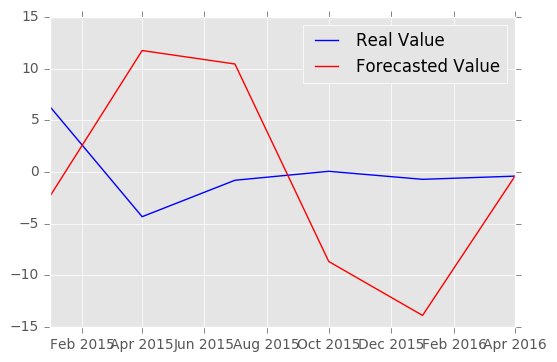

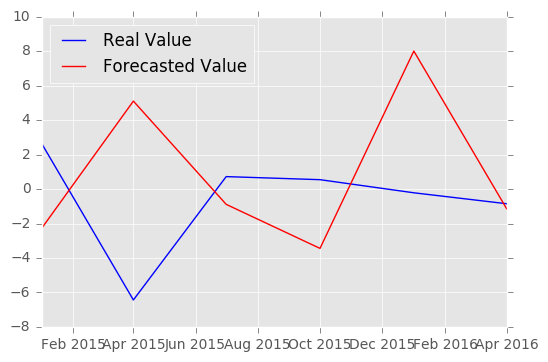

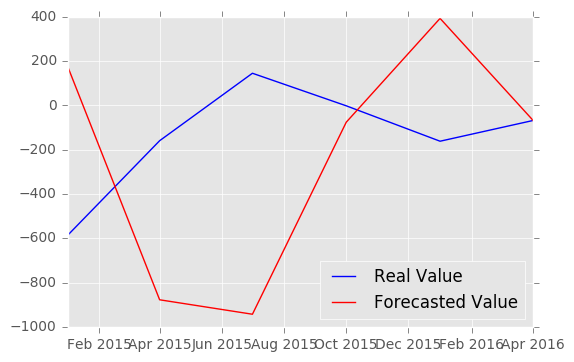

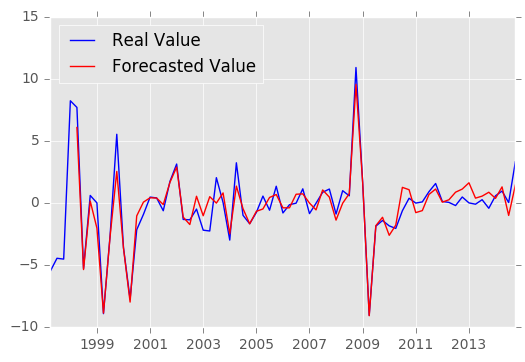

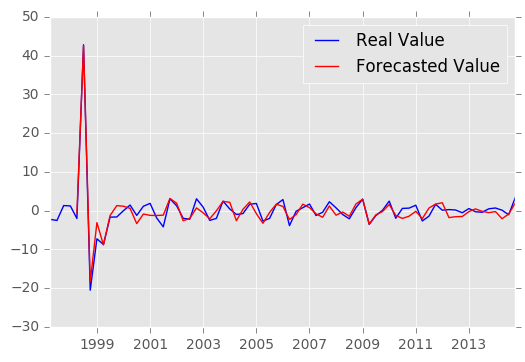

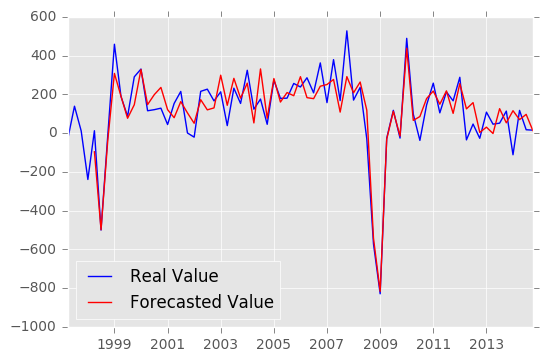

In [51]:
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['gdp'], test['gdp']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['gdp'], test['gdp'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['gdp'], train['gdp'])

{'mse': 100.37384073939053, 'mae': 8.516017817477227, 'rmse': 10.018674599935389}
{'mse': 43.28398640824107, 'mae': 5.9594154124567638, 'rmse': 6.5790566503292149}
{'mse': 595467.18953580467, 'mae': 683.44008817323811, 'rmse': 771.66520560137008}


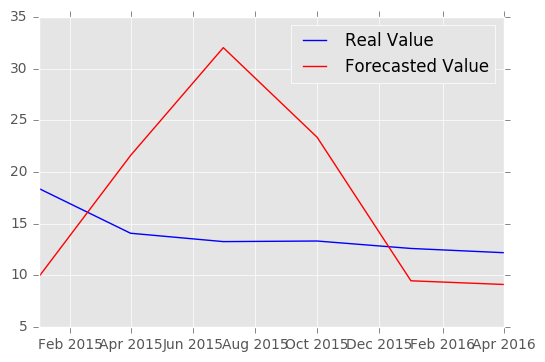

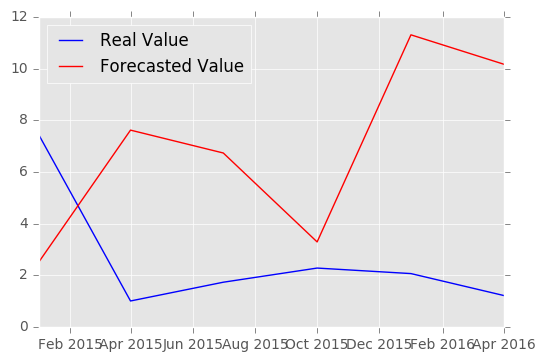

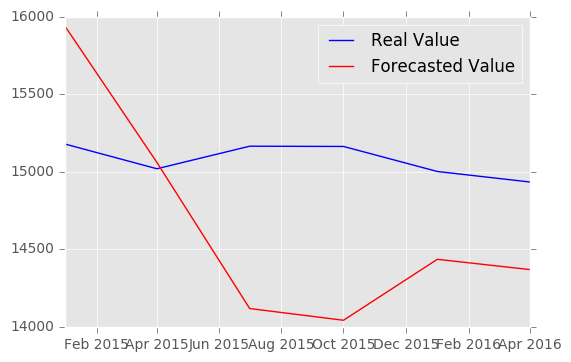

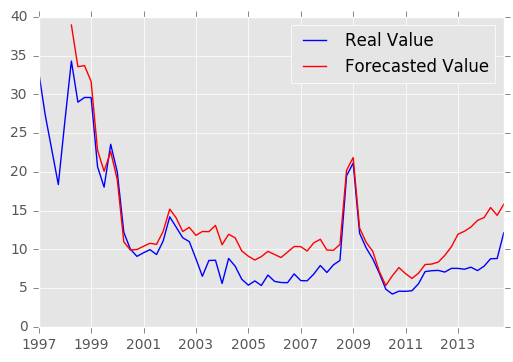

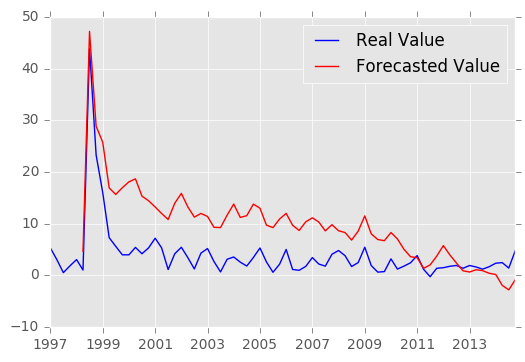

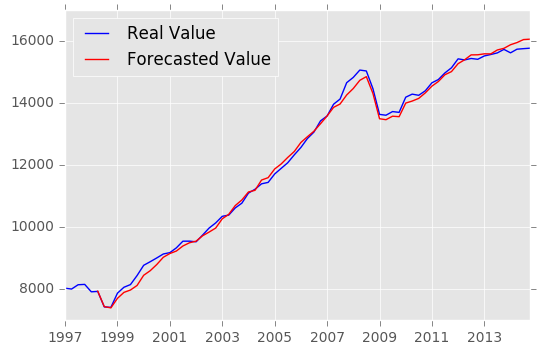

In [52]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['gdp'], test_real['gdp']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['gdp'], test_real['gdp'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['gdp'], train_real['gdp'])

С DropOut

In [53]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
0s - loss: 1.9462
Epoch 2/600
0s - loss: 1.5167
Epoch 3/600
0s - loss: 1.2286
Epoch 4/600
0s - loss: 1.1245
Epoch 5/600
0s - loss: 1.0766
Epoch 6/600
0s - loss: 1.0245
Epoch 7/600
0s - loss: 1.0170
Epoch 8/600
0s - loss: 1.0251
Epoch 9/600
0s - loss: 1.0035
Epoch 10/600
0s - loss: 1.0140
Epoch 11/600
0s - loss: 1.0045
Epoch 12/600
0s - loss: 1.0157
Epoch 13/600
0s - loss: 1.0076
Epoch 14/600
0s - loss: 1.0153
Epoch 15/600
0s - loss: 0.9793
Epoch 16/600
0s - loss: 0.9871
Epoch 17/600
0s - loss: 0.9955
Epoch 18/600
0s - loss: 0.9909
Epoch 19/600
0s - loss: 0.9863
Epoch 20/600
0s - loss: 0.9916
Epoch 21/600
0s - loss: 0.9785
Epoch 22/600
0s - loss: 0.9812
Epoch 23/600
0s - loss: 0.9852
Epoch 24/600
0s - loss: 0.9745
Epoch 25/600
0s - loss: 0.9881
Epoch 26/600
0s - loss: 0.9979
Epoch 27/600
0s - loss: 0.9769
Epoch 28/600
0s - loss: 0.9911
Epoch 29/600
0s - loss: 0.9584
Epoch 30/600
0s - loss: 0.9948
Epoch 31/600
0s - loss: 0.9892
Epoch 32/600
0s - loss: 1.0191
Epoch 33/600
0s -

{'mse': 32.149118445784104, 'mae': 4.5241626385225988, 'rmse': 5.6700192632639359}
{'mse': 54.18953727308579, 'mae': 4.4052945838655377, 'rmse': 7.3613543097099861}
{'mse': 135809.00180738018, 'mae': 326.89355287881102, 'rmse': 368.52272902411346}


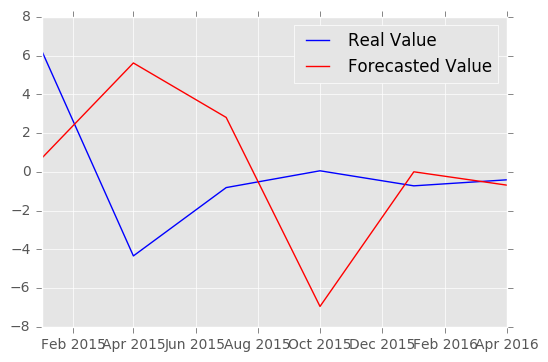

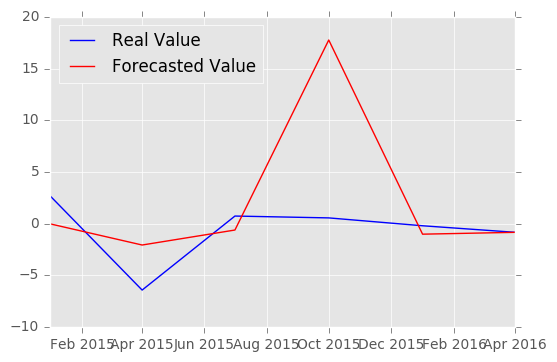

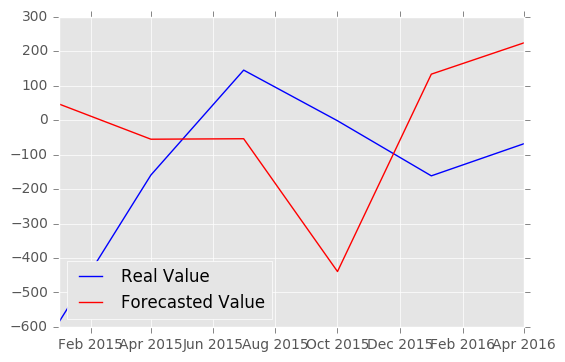

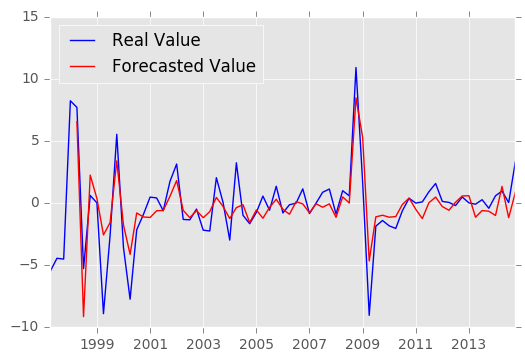

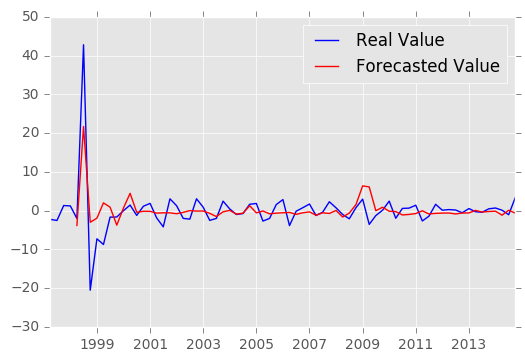

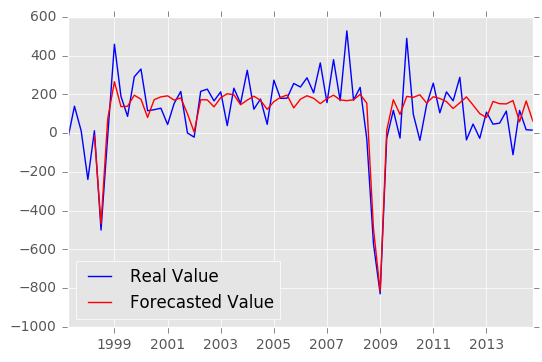

In [54]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['gdp'], test['gdp']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['gdp'], test['gdp'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['gdp'], train['gdp'])

{'mse': 20.10111314021929, 'mae': 3.695564974445547, 'rmse': 4.483426495462961}
{'mse': 146.1274573474293, 'mae': 9.2757411401735563, 'rmse': 12.088319045567474}
{'mse': 311519.80109362368, 'mae': 514.61176143034788, 'rmse': 558.13958925489567}


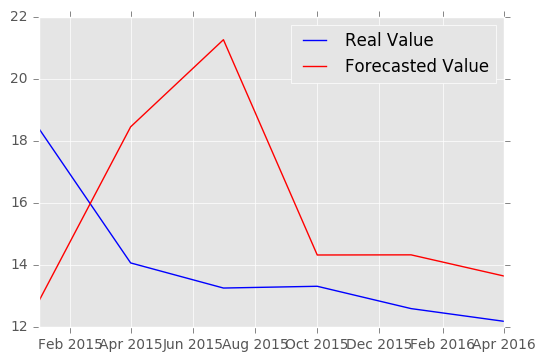

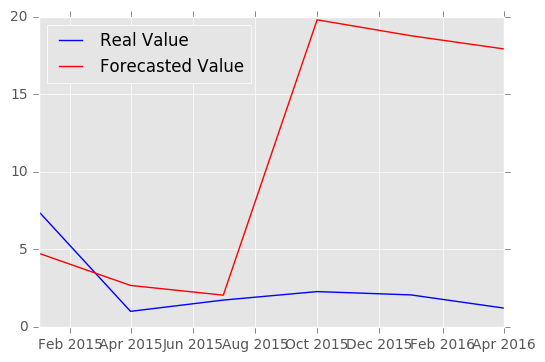

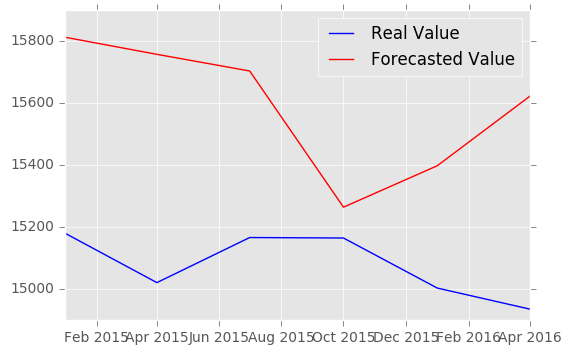

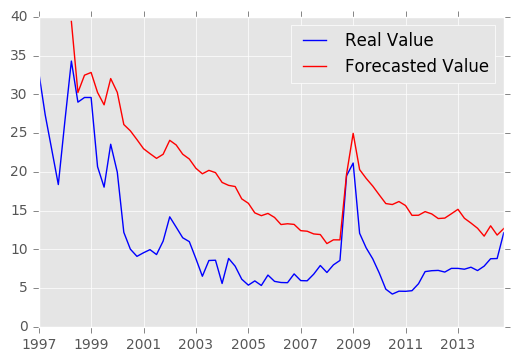

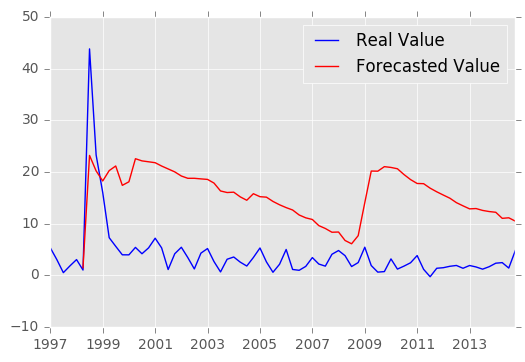

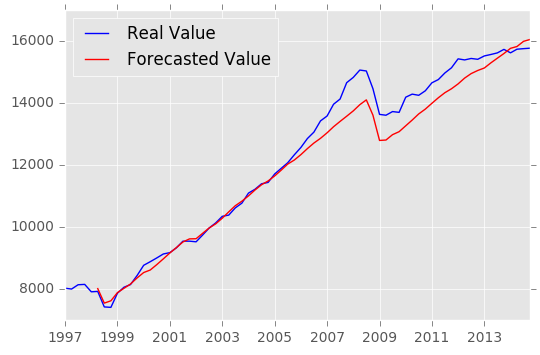

In [55]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['gdp'], test_real['gdp']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['gdp'], test_real['gdp'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['gdp'], train_real['gdp'])

На оригинальных данных, а не разницах

In [56]:
df_nn = nn_transform(train_real, n=LAG)
df_nn_s, m, s = scaler(df_nn)
train_nn_x = df_nn_s.iloc[:, 3:].copy()
train_nn_y = df_nn_s.iloc[:, :3].copy()

In [57]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
0s - loss: 1.6624
Epoch 2/600
0s - loss: 1.1986
Epoch 3/600
0s - loss: 1.0208
Epoch 4/600
0s - loss: 0.9323
Epoch 5/600
0s - loss: 0.8795
Epoch 6/600
0s - loss: 0.8323
Epoch 7/600
0s - loss: 0.7934
Epoch 8/600
0s - loss: 0.7498
Epoch 9/600
0s - loss: 0.7128
Epoch 10/600
0s - loss: 0.6748
Epoch 11/600
0s - loss: 0.6396
Epoch 12/600
0s - loss: 0.6106
Epoch 13/600
0s - loss: 0.5845
Epoch 14/600
0s - loss: 0.5633
Epoch 15/600
0s - loss: 0.5446
Epoch 16/600
0s - loss: 0.5295
Epoch 17/600
0s - loss: 0.5174
Epoch 18/600
0s - loss: 0.5063
Epoch 19/600
0s - loss: 0.4984
Epoch 20/600
0s - loss: 0.4893
Epoch 21/600
0s - loss: 0.4819
Epoch 22/600
0s - loss: 0.4742
Epoch 23/600
0s - loss: 0.4683
Epoch 24/600
0s - loss: 0.4599
Epoch 25/600
0s - loss: 0.4531
Epoch 26/600
0s - loss: 0.4478
Epoch 27/600
0s - loss: 0.4414
Epoch 28/600
0s - loss: 0.4362
Epoch 29/600
0s - loss: 0.4284
Epoch 30/600
0s - loss: 0.4238
Epoch 31/600
0s - loss: 0.4154
Epoch 32/600
0s - loss: 0.4117
Epoch 33/600
0s -

{'mse': 63.378962860192217, 'mae': 7.0141200229661651, 'rmse': 7.9610905572159032}
{'mse': 373.45822692590326, 'mae': 12.51704658541871, 'rmse': 19.325067320087225}
{'mse': 14765911.92724064, 'mae': 3029.8205653903065, 'rmse': 3842.6438720288197}


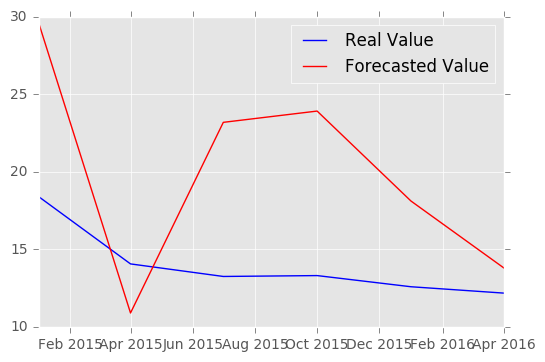

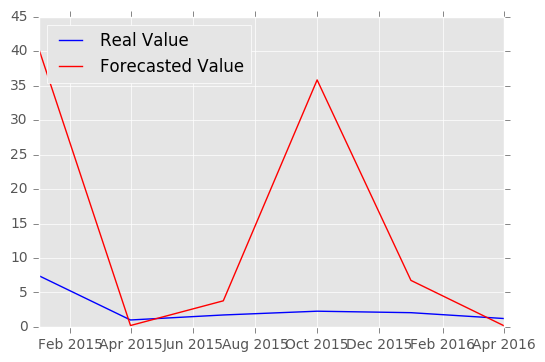

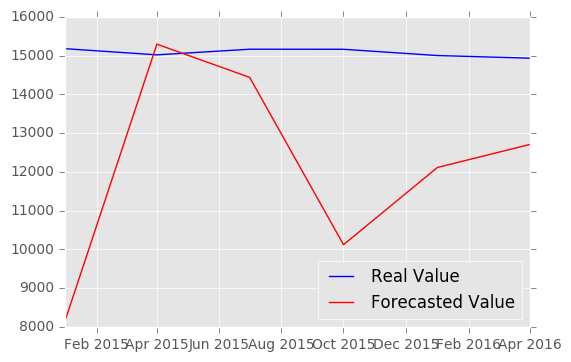

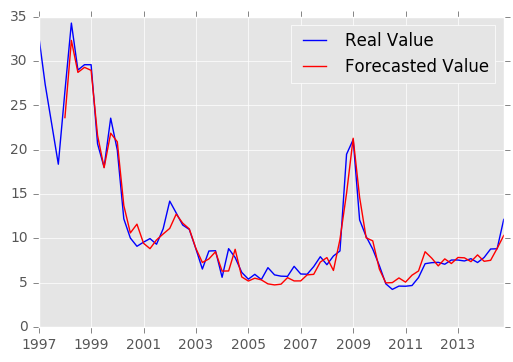

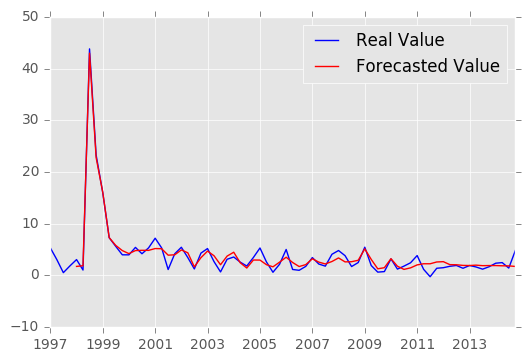

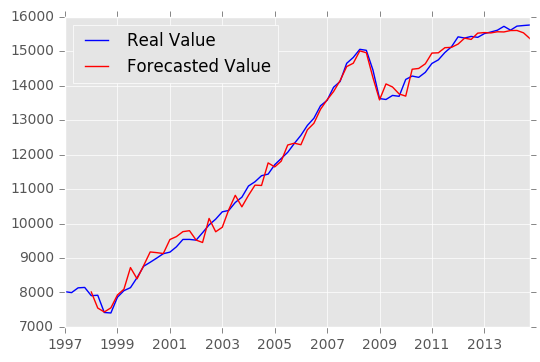

In [58]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['gdp'], test_real['gdp']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['gdp'], test_real['gdp'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['gdp'], train_real['gdp'])

Второй запуск (не на разницах)

In [59]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
0s - loss: 1.1323
Epoch 2/600
0s - loss: 0.9898
Epoch 3/600
0s - loss: 0.9108
Epoch 4/600
0s - loss: 0.8540
Epoch 5/600
0s - loss: 0.8005
Epoch 6/600
0s - loss: 0.7549
Epoch 7/600
0s - loss: 0.7063
Epoch 8/600
0s - loss: 0.6685
Epoch 9/600
0s - loss: 0.6307
Epoch 10/600
0s - loss: 0.6042
Epoch 11/600
0s - loss: 0.5798
Epoch 12/600
0s - loss: 0.5571
Epoch 13/600
0s - loss: 0.5402
Epoch 14/600
0s - loss: 0.5307
Epoch 15/600
0s - loss: 0.5159
Epoch 16/600
0s - loss: 0.5047
Epoch 17/600
0s - loss: 0.4959
Epoch 18/600
0s - loss: 0.4887
Epoch 19/600
0s - loss: 0.4803
Epoch 20/600
0s - loss: 0.4738
Epoch 21/600
0s - loss: 0.4659
Epoch 22/600
0s - loss: 0.4611
Epoch 23/600
0s - loss: 0.4569
Epoch 24/600
0s - loss: 0.4485
Epoch 25/600
0s - loss: 0.4409
Epoch 26/600
0s - loss: 0.4356
Epoch 27/600
0s - loss: 0.4290
Epoch 28/600
0s - loss: 0.4219
Epoch 29/600
0s - loss: 0.4161
Epoch 30/600
0s - loss: 0.4106
Epoch 31/600
0s - loss: 0.4046
Epoch 32/600
0s - loss: 0.4008
Epoch 33/600
0s -

{'mse': 47.85556050908037, 'mae': 6.2482290353244307, 'rmse': 6.9177713542065247}
{'mse': 355.53949313511242, 'mae': 12.848539872379639, 'rmse': 18.855754907590214}
{'mse': 17589607.879250228, 'mae': 3179.7838402674911, 'rmse': 4193.9966475010715}


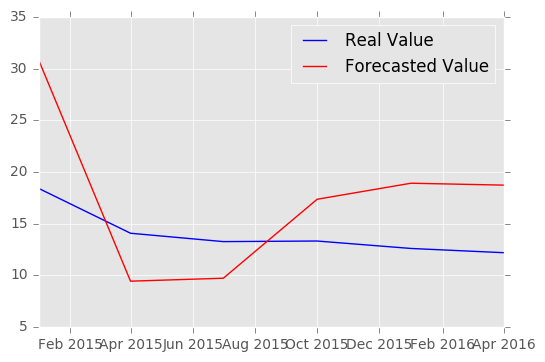

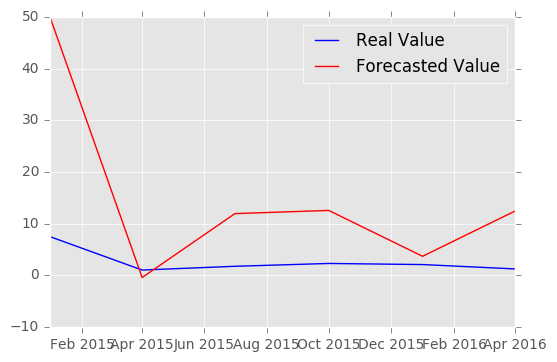

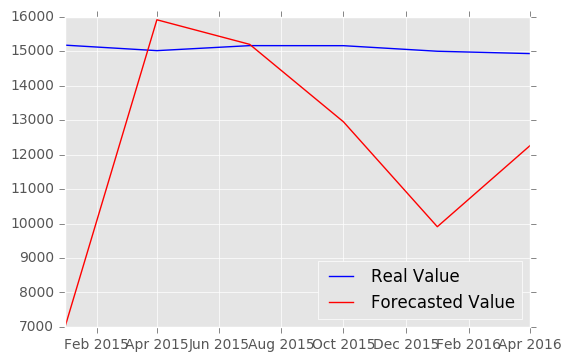

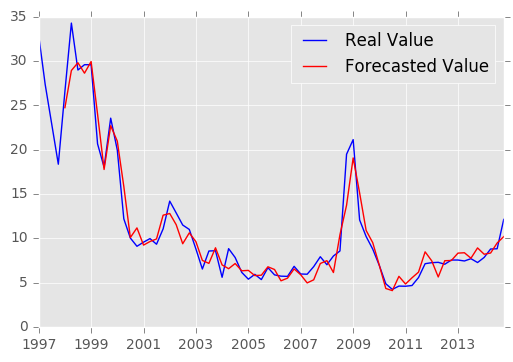

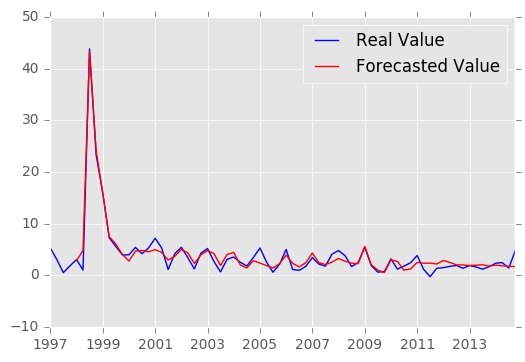

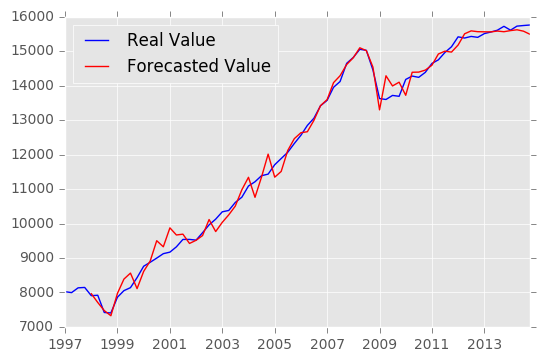

In [60]:
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['gdp'], test_real['gdp']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['gdp'], test_real['gdp'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['gdp'], train_real['gdp'])

С DropOut

In [61]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
0s - loss: 1.0909
Epoch 2/600
0s - loss: 0.9719
Epoch 3/600
0s - loss: 0.8992
Epoch 4/600
0s - loss: 0.8373
Epoch 5/600
0s - loss: 0.7785
Epoch 6/600
0s - loss: 0.7249
Epoch 7/600
0s - loss: 0.6754
Epoch 8/600
0s - loss: 0.6327
Epoch 9/600
0s - loss: 0.5979
Epoch 10/600
0s - loss: 0.5644
Epoch 11/600
0s - loss: 0.5422
Epoch 12/600
0s - loss: 0.5185
Epoch 13/600
0s - loss: 0.5039
Epoch 14/600
0s - loss: 0.4909
Epoch 15/600
0s - loss: 0.4797
Epoch 16/600
0s - loss: 0.4692
Epoch 17/600
0s - loss: 0.4596
Epoch 18/600
0s - loss: 0.4511
Epoch 19/600
0s - loss: 0.4437
Epoch 20/600
0s - loss: 0.4371
Epoch 21/600
0s - loss: 0.4302
Epoch 22/600
0s - loss: 0.4246
Epoch 23/600
0s - loss: 0.4185
Epoch 24/600
0s - loss: 0.4141
Epoch 25/600
0s - loss: 0.4067
Epoch 26/600
0s - loss: 0.4011
Epoch 27/600
0s - loss: 0.3955
Epoch 28/600
0s - loss: 0.3896
Epoch 29/600
0s - loss: 0.3856
Epoch 30/600
0s - loss: 0.3792
Epoch 31/600
0s - loss: 0.3737
Epoch 32/600
0s - loss: 0.3681
Epoch 33/600
0s -

{'mse': 124.07894416323091, 'mae': 9.3006664724920061, 'rmse': 11.139072859229843}
{'mse': 1.6664955264368446, 'mae': 1.0181986712485249, 'rmse': 1.2909281647081856}
{'mse': 9062408.3762492277, 'mae': 2174.6235438753779, 'rmse': 3010.383426782912}


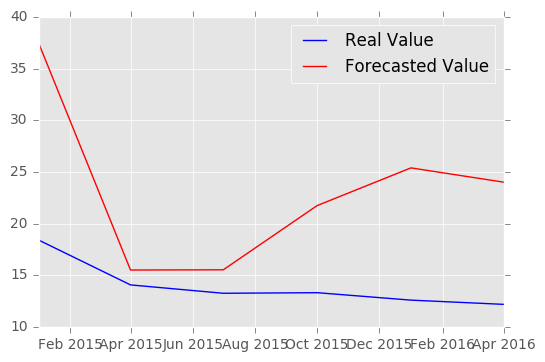

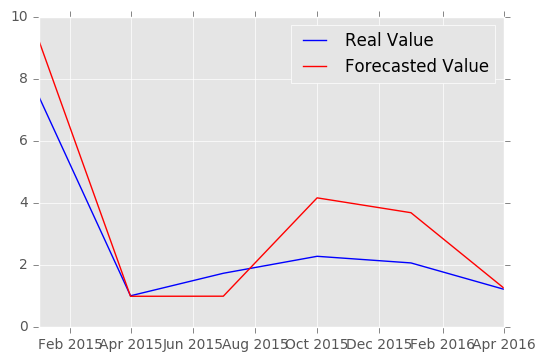

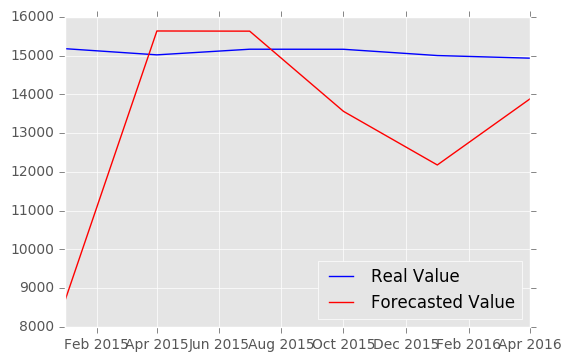

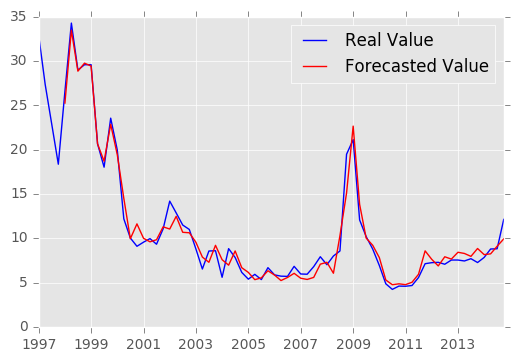

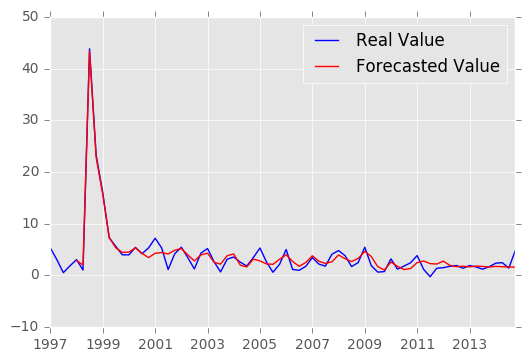

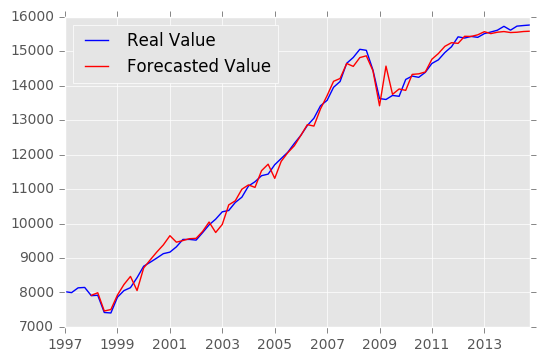

In [62]:
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['gdp'], test_real['gdp']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['gdp'], test_real['gdp'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['gdp'], train_real['gdp'])

## Hybrid

In [63]:
def hybrid_model(train, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    
    resid_df = pd.DataFrame(fitm.resid)
    resid_df.columns = train.columns
    
    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_result + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

In [64]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [65]:
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='q')

Epoch 1/200
0s - loss: 1.1851
Epoch 2/200
0s - loss: 1.0534
Epoch 3/200
0s - loss: 1.0099
Epoch 4/200
0s - loss: 0.9918
Epoch 5/200
0s - loss: 0.9864
Epoch 6/200
0s - loss: 0.9821
Epoch 7/200
0s - loss: 0.9782
Epoch 8/200
0s - loss: 0.9774
Epoch 9/200
0s - loss: 0.9732
Epoch 10/200
0s - loss: 0.9725
Epoch 11/200
0s - loss: 0.9698
Epoch 12/200
0s - loss: 0.9667
Epoch 13/200
0s - loss: 0.9623
Epoch 14/200
0s - loss: 0.9593
Epoch 15/200
0s - loss: 0.9557
Epoch 16/200
0s - loss: 0.9537
Epoch 17/200
0s - loss: 0.9496
Epoch 18/200
0s - loss: 0.9471
Epoch 19/200
0s - loss: 0.9460
Epoch 20/200
0s - loss: 0.9428
Epoch 21/200
0s - loss: 0.9391
Epoch 22/200
0s - loss: 0.9393
Epoch 23/200
0s - loss: 0.9348
Epoch 24/200
0s - loss: 0.9301
Epoch 25/200
0s - loss: 0.9289
Epoch 26/200
0s - loss: 0.9243
Epoch 27/200
0s - loss: 0.9190
Epoch 28/200
0s - loss: 0.9189
Epoch 29/200
0s - loss: 0.9156
Epoch 30/200
0s - loss: 0.9139
Epoch 31/200
0s - loss: 0.9095
Epoch 32/200
0s - loss: 0.9093
Epoch 33/200
0s -

{'mse': 8.1945490358733366, 'mae': 1.9176486706098608, 'rmse': 2.8626122748065859}
{'mse': 11.454797430817777, 'mae': 2.8202119125698197, 'rmse': 3.3844936742174268}
{'mse': 60126.072447824728, 'mae': 212.74517247075769, 'rmse': 245.20618354320661}


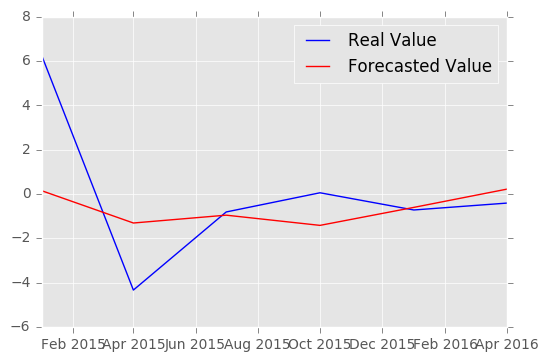

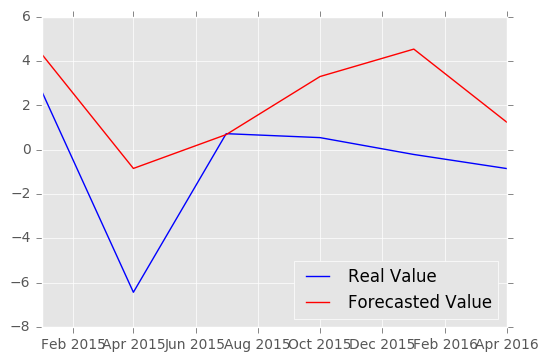

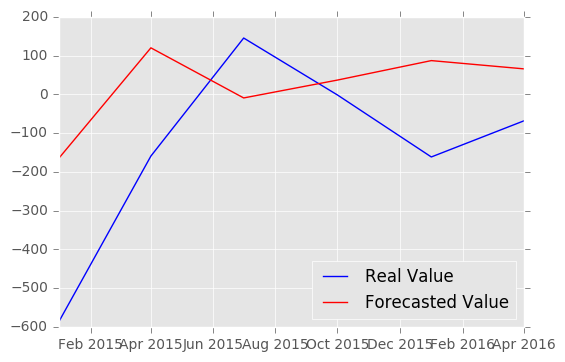

In [66]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['gdp'], test['gdp']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['gdp'], test['gdp'])

{'mse': 19.370501557210456, 'mae': 4.2808759646120595, 'rmse': 4.4011931969876601}
{'mse': 118.00848200657003, 'mae': 9.6189383728885218, 'rmse': 10.863170900182416}
{'mse': 489766.23196882335, 'mae': 675.57242965074636, 'rmse': 699.83300291485489}


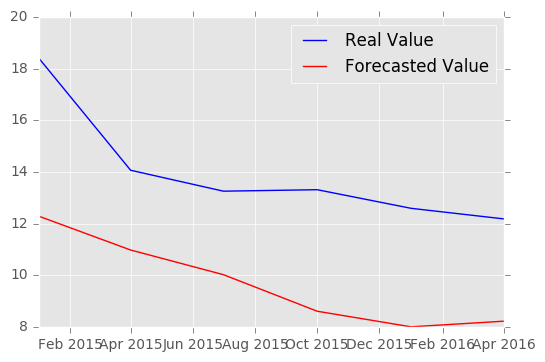

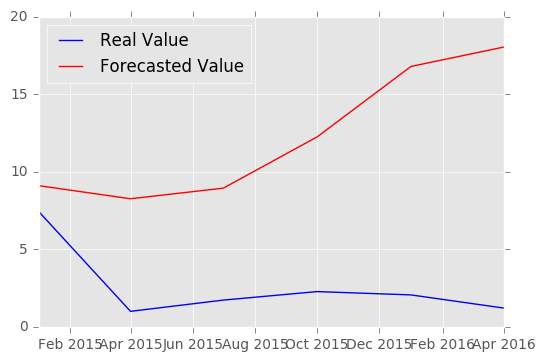

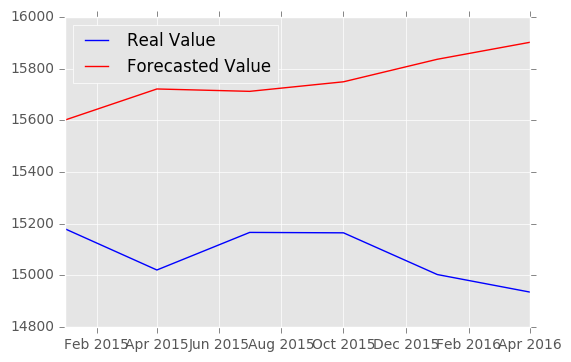

In [67]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['gdp'], test_real['gdp']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['gdp'], test_real['gdp'])

Второй запуск

In [68]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='q')

Epoch 1/200
0s - loss: 1.1858
Epoch 2/200
0s - loss: 1.0557
Epoch 3/200
0s - loss: 1.0074
Epoch 4/200
0s - loss: 0.9908
Epoch 5/200
0s - loss: 0.9816
Epoch 6/200
0s - loss: 0.9742
Epoch 7/200
0s - loss: 0.9730
Epoch 8/200
0s - loss: 0.9710
Epoch 9/200
0s - loss: 0.9618
Epoch 10/200
0s - loss: 0.9571
Epoch 11/200
0s - loss: 0.9548
Epoch 12/200
0s - loss: 0.9475
Epoch 13/200
0s - loss: 0.9445
Epoch 14/200
0s - loss: 0.9380
Epoch 15/200
0s - loss: 0.9338
Epoch 16/200
0s - loss: 0.9316
Epoch 17/200
0s - loss: 0.9245
Epoch 18/200
0s - loss: 0.9234
Epoch 19/200
0s - loss: 0.9157
Epoch 20/200
0s - loss: 0.9113
Epoch 21/200
0s - loss: 0.9075
Epoch 22/200
0s - loss: 0.9003
Epoch 23/200
0s - loss: 0.8969
Epoch 24/200
0s - loss: 0.8930
Epoch 25/200
0s - loss: 0.8824
Epoch 26/200
0s - loss: 0.8795
Epoch 27/200
0s - loss: 0.8734
Epoch 28/200
0s - loss: 0.8722
Epoch 29/200
0s - loss: 0.8663
Epoch 30/200
0s - loss: 0.8628
Epoch 31/200
0s - loss: 0.8595
Epoch 32/200
0s - loss: 0.8518
Epoch 33/200
0s -

{'mse': 6.9333229615683107, 'mae': 2.1418970265551436, 'rmse': 2.6331203849365319}
{'mse': 17.953535793309328, 'mae': 3.1000777106236583, 'rmse': 4.2371612895084994}
{'mse': 72159.274675985725, 'mae': 220.31360577847946, 'rmse': 268.62478418043582}


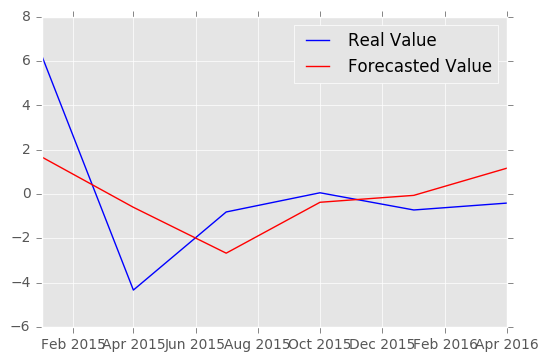

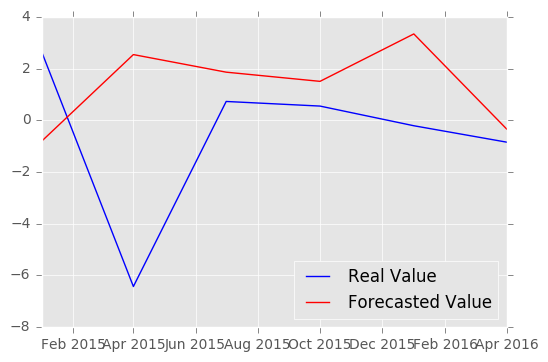

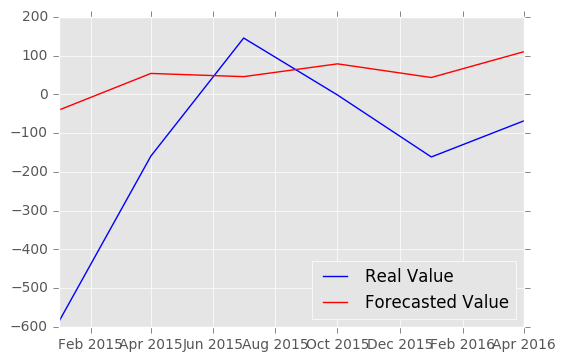

In [69]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['gdp'], test['gdp']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['gdp'], test['gdp'])

{'mse': 7.6717405964232235, 'mae': 2.4485741919758186, 'rmse': 2.7697907134697424}
{'mse': 67.456890885651475, 'mae': 7.673221269826155, 'rmse': 8.2132144064094348}
{'mse': 667449.50888472574, 'mae': 794.74255608861165, 'rmse': 816.97583127331598}


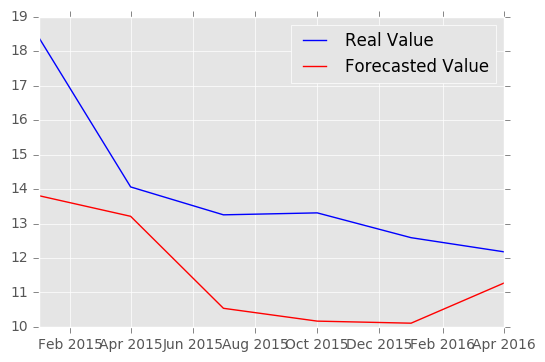

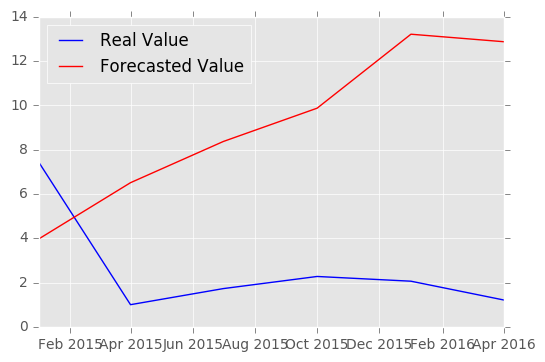

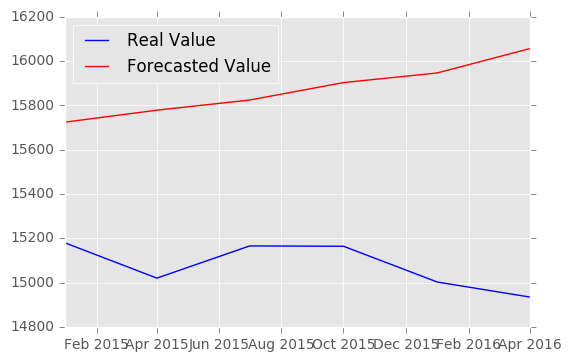

In [70]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['gdp'], test_real['gdp']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['gdp'], test_real['gdp'])

С DropOut

In [71]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='q')

Epoch 1/200
0s - loss: 1.2856
Epoch 2/200
0s - loss: 1.1628
Epoch 3/200
0s - loss: 1.0435
Epoch 4/200
0s - loss: 1.0329
Epoch 5/200
0s - loss: 1.0813
Epoch 6/200
0s - loss: 1.0342
Epoch 7/200
0s - loss: 0.9305
Epoch 8/200
0s - loss: 1.0158
Epoch 9/200
0s - loss: 1.0015
Epoch 10/200
0s - loss: 1.0225
Epoch 11/200
0s - loss: 1.0040
Epoch 12/200
0s - loss: 1.0208
Epoch 13/200
0s - loss: 0.9787
Epoch 14/200
0s - loss: 0.9967
Epoch 15/200
0s - loss: 0.9991
Epoch 16/200
0s - loss: 0.9736
Epoch 17/200
0s - loss: 0.9552
Epoch 18/200
0s - loss: 0.9562
Epoch 19/200
0s - loss: 0.9695
Epoch 20/200
0s - loss: 0.9660
Epoch 21/200
0s - loss: 0.9331
Epoch 22/200
0s - loss: 0.9996
Epoch 23/200
0s - loss: 0.9579
Epoch 24/200
0s - loss: 0.9427
Epoch 25/200
0s - loss: 0.9337
Epoch 26/200
0s - loss: 0.9259
Epoch 27/200
0s - loss: 0.9656
Epoch 28/200
0s - loss: 0.9782
Epoch 29/200
0s - loss: 0.9512
Epoch 30/200
0s - loss: 0.9834
Epoch 31/200
0s - loss: 0.9373
Epoch 32/200
0s - loss: 0.9218
Epoch 33/200
0s -

{'mse': 6.6516286259936779, 'mae': 1.6386511543114322, 'rmse': 2.579075149349797}
{'mse': 7.8608073985496238, 'mae': 1.6730976615267474, 'rmse': 2.8037131448401822}
{'mse': 84529.288143637968, 'mae': 246.78039238926897, 'rmse': 290.73920984902941}


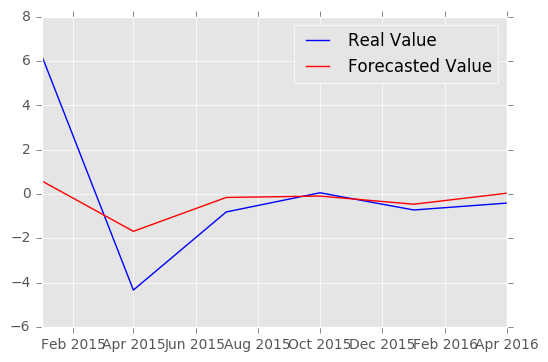

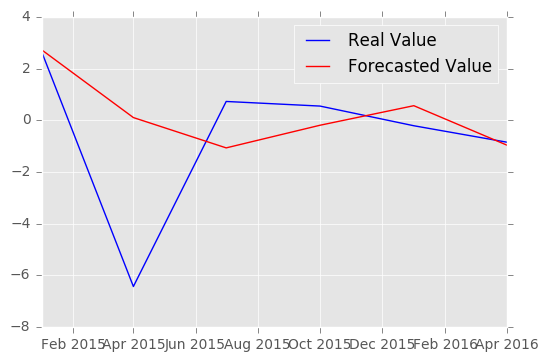

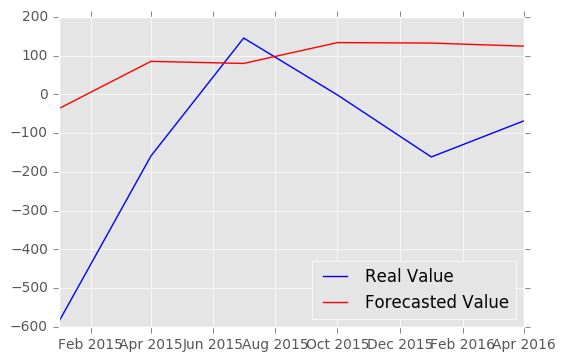

In [72]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['gdp'], test['gdp']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['gdp'], test['gdp'])

{'mse': 10.249044541755424, 'mae': 2.9370879113858961, 'rmse': 3.2014128977305356}
{'mse': 21.574345250810214, 'mae': 4.1930124042255486, 'rmse': 4.6448191838660646}
{'mse': 894240.16064670635, 'mae': 906.64302706312901, 'rmse': 945.64272357307675}


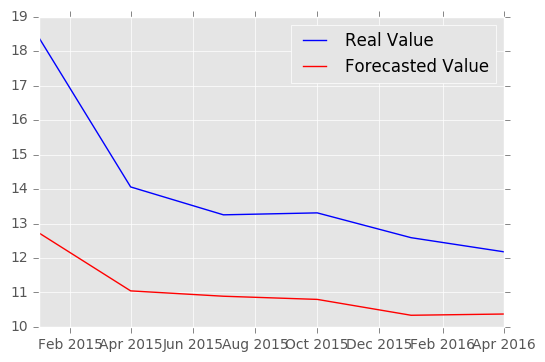

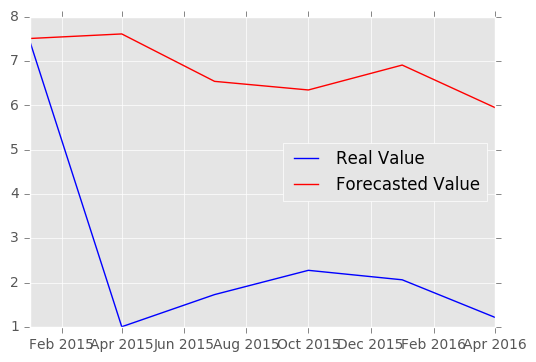

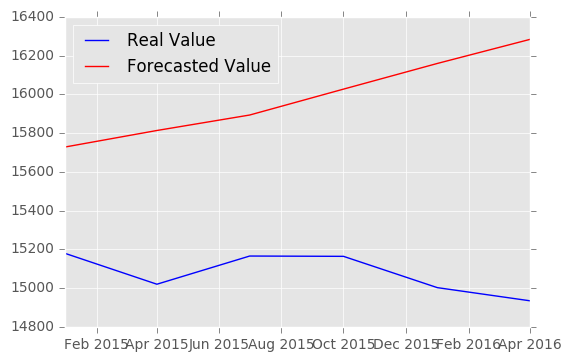

In [73]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['gdp'], test_real['gdp']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['gdp'], test_real['gdp'])

### Hybrid_full

In [74]:
#def hybrid_model(train, lags, steps, model_nn, years=True, epoch=100, period='m'):
# lags = LAG
# steps=STEPS
# model_nn=nn
# years=True
# epoch=200
# period='q'

def hybrid_model_undiff(train, train_real, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    var_in = undiff(previous_df=train_real.head(1), diff_df=pd.DataFrame(fitm.fittedvalues))
    var_out = undiff(previous_df=train_real, diff_df=pd.DataFrame(var_result))
    resid_df = pd.DataFrame(train_real.iloc[lags+1:, :].as_matrix() - var_in.as_matrix())
    resid_df.columns = train.columns

    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_out.as_matrix() + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns

    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3

    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

Первый запуск

In [75]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='q')

Epoch 1/500
0s - loss: 1.0496
Epoch 2/500
0s - loss: 0.9873
Epoch 3/500
0s - loss: 0.9476
Epoch 4/500
0s - loss: 0.9181
Epoch 5/500
0s - loss: 0.8837
Epoch 6/500
0s - loss: 0.8583
Epoch 7/500
0s - loss: 0.8272
Epoch 8/500
0s - loss: 0.7942
Epoch 9/500
0s - loss: 0.7679
Epoch 10/500
0s - loss: 0.7386
Epoch 11/500
0s - loss: 0.7121
Epoch 12/500
0s - loss: 0.6846
Epoch 13/500
0s - loss: 0.6612
Epoch 14/500
0s - loss: 0.6361
Epoch 15/500
0s - loss: 0.6137
Epoch 16/500
0s - loss: 0.5900
Epoch 17/500
0s - loss: 0.5707
Epoch 18/500
0s - loss: 0.5486
Epoch 19/500
0s - loss: 0.5300
Epoch 20/500
0s - loss: 0.5141
Epoch 21/500
0s - loss: 0.4965
Epoch 22/500
0s - loss: 0.4809
Epoch 23/500
0s - loss: 0.4665
Epoch 24/500
0s - loss: 0.4536
Epoch 25/500
0s - loss: 0.4396
Epoch 26/500
0s - loss: 0.4275
Epoch 27/500
0s - loss: 0.4167
Epoch 28/500
0s - loss: 0.4082
Epoch 29/500
0s - loss: 0.3983
Epoch 30/500
0s - loss: 0.3892
Epoch 31/500
0s - loss: 0.3825
Epoch 32/500
0s - loss: 0.3751
Epoch 33/500
0s -

{'mse': 488.85639841972335, 'mae': 22.049031395903, 'rmse': 22.110097205117018}
{'mse': 37.31178500620976, 'mae': 5.8884352496293859, 'rmse': 6.1083373356593329}
{'mse': 902862.44029677834, 'mae': 854.23161313903472, 'rmse': 950.19073890286802}


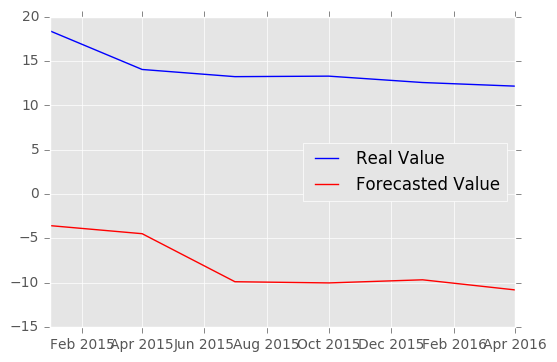

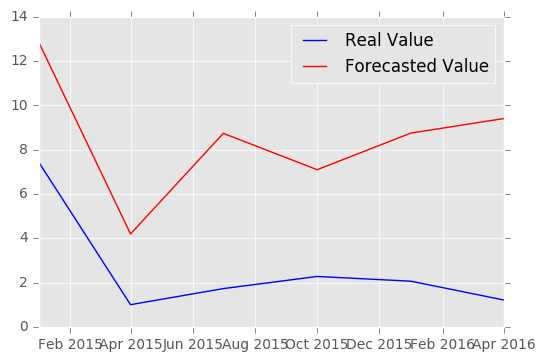

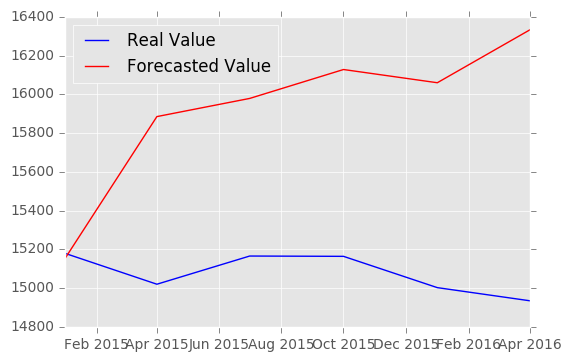

In [76]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['gdp'], test_real['gdp']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['gdp'], test_real['gdp'])

Второй запуск

In [77]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='q')

Epoch 1/500
0s - loss: 1.9057
Epoch 2/500
0s - loss: 1.4060
Epoch 3/500
0s - loss: 1.1661
Epoch 4/500
0s - loss: 1.0430
Epoch 5/500
0s - loss: 0.9716
Epoch 6/500
0s - loss: 0.9217
Epoch 7/500
0s - loss: 0.8860
Epoch 8/500
0s - loss: 0.8557
Epoch 9/500
0s - loss: 0.8309
Epoch 10/500
0s - loss: 0.8066
Epoch 11/500
0s - loss: 0.7854
Epoch 12/500
0s - loss: 0.7624
Epoch 13/500
0s - loss: 0.7434
Epoch 14/500
0s - loss: 0.7191
Epoch 15/500
0s - loss: 0.6972
Epoch 16/500
0s - loss: 0.6750
Epoch 17/500
0s - loss: 0.6542
Epoch 18/500
0s - loss: 0.6346
Epoch 19/500
0s - loss: 0.6148
Epoch 20/500
0s - loss: 0.5979
Epoch 21/500
0s - loss: 0.5795
Epoch 22/500
0s - loss: 0.5606
Epoch 23/500
0s - loss: 0.5412
Epoch 24/500
0s - loss: 0.5278
Epoch 25/500
0s - loss: 0.5104
Epoch 26/500
0s - loss: 0.4961
Epoch 27/500
0s - loss: 0.4819
Epoch 28/500
0s - loss: 0.4673
Epoch 29/500
0s - loss: 0.4571
Epoch 30/500
0s - loss: 0.4442
Epoch 31/500
0s - loss: 0.4334
Epoch 32/500
0s - loss: 0.4225
Epoch 33/500
0s -

{'mse': 470.70599999162664, 'mae': 21.542519404805251, 'rmse': 21.695759954231303}
{'mse': 52.83857784057053, 'mae': 6.7428034846013389, 'rmse': 7.2690149154180812}
{'mse': 618777.3621628026, 'mae': 683.85676754820508, 'rmse': 786.62402846773159}


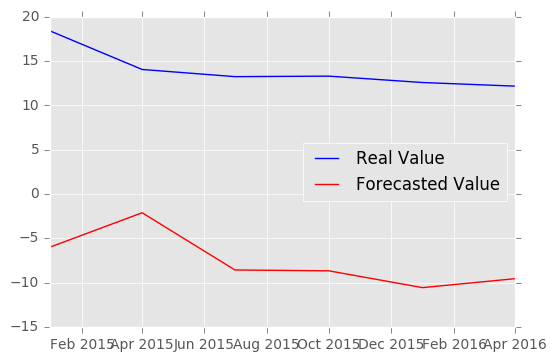

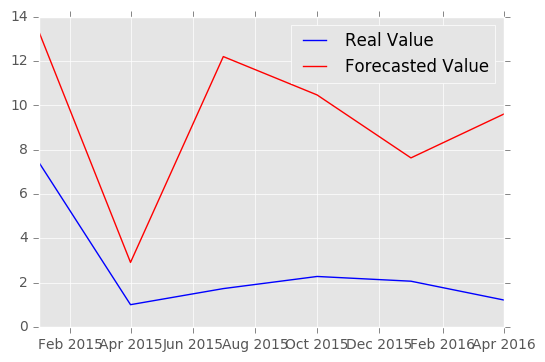

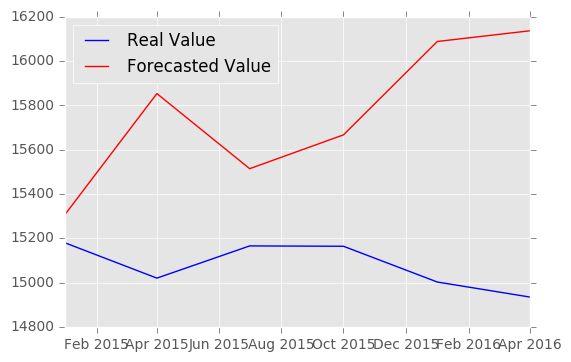

In [78]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['gdp'], test_real['gdp']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['gdp'], test_real['gdp'])

С DropOut

In [79]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='q')

Epoch 1/500
0s - loss: 1.2544
Epoch 2/500
0s - loss: 1.0901
Epoch 3/500
0s - loss: 1.0301
Epoch 4/500
0s - loss: 0.9697
Epoch 5/500
0s - loss: 1.0002
Epoch 6/500
0s - loss: 0.9934
Epoch 7/500
0s - loss: 1.0065
Epoch 8/500
0s - loss: 0.9660
Epoch 9/500
0s - loss: 0.9459
Epoch 10/500
0s - loss: 0.9906
Epoch 11/500
0s - loss: 0.9773
Epoch 12/500
0s - loss: 0.9639
Epoch 13/500
0s - loss: 0.9471
Epoch 14/500
0s - loss: 0.9589
Epoch 15/500
0s - loss: 0.9316
Epoch 16/500
0s - loss: 0.9524
Epoch 17/500
0s - loss: 0.9221
Epoch 18/500
0s - loss: 0.9543
Epoch 19/500
0s - loss: 0.9443
Epoch 20/500
0s - loss: 0.9699
Epoch 21/500
0s - loss: 0.9465
Epoch 22/500
0s - loss: 0.9272
Epoch 23/500
0s - loss: 0.9007
Epoch 24/500
0s - loss: 0.9287
Epoch 25/500
0s - loss: 0.9011
Epoch 26/500
0s - loss: 0.9236
Epoch 27/500
0s - loss: 0.9033
Epoch 28/500
0s - loss: 0.8994
Epoch 29/500
0s - loss: 0.9461
Epoch 30/500
0s - loss: 0.8860
Epoch 31/500
0s - loss: 0.8879
Epoch 32/500
0s - loss: 0.9146
Epoch 33/500
0s -

{'mse': 492.63239519280182, 'mae': 22.134426170491945, 'rmse': 22.195323723541449}
{'mse': 72.441502242960738, 'mae': 8.1539939225792342, 'rmse': 8.5112573831931986}
{'mse': 804441.29371941742, 'mae': 848.94269630650558, 'rmse': 896.90651336659243}


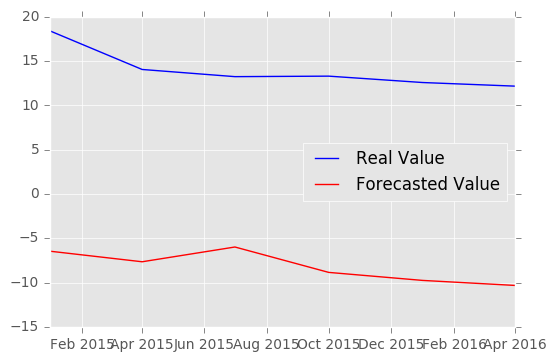

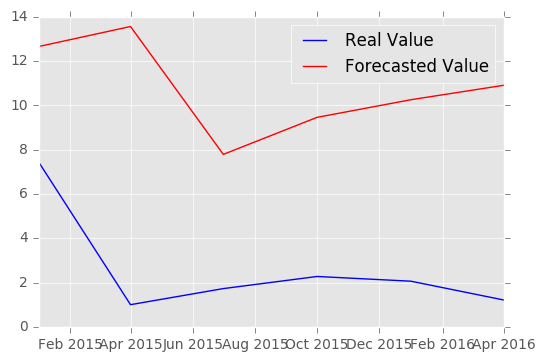

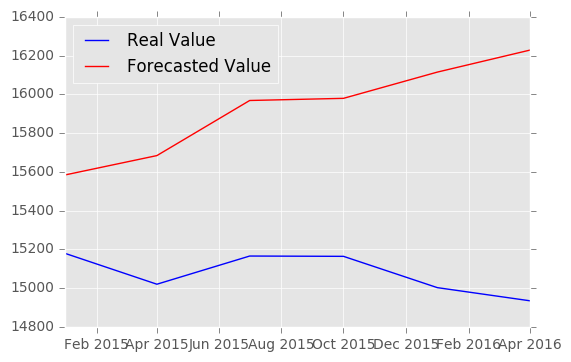

In [80]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['gdp'], test_real['gdp']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['gdp'], test_real['gdp'])